In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec, cumulative_trapezoid, simpson
from tqdm import tqdm
import timeit

In [85]:
"""
Constants
"""
# --> Pulse <--
wl = 0.057                      # au
epsilon = 1
intensity = 10e14 / 3.51e16     # au
phi = 0
Nc = 1
T = Nc * 2*np.pi/wl

F0 = np.sqrt(intensity)
A0 = F0 / wl

Up = A0**2 * 0.25

def envelope(t) : 
    global wl, Nc, T
    return np.sin(np.pi*t/T)**2

# --> System <--
E0 = -0.5                       # au


In [86]:
def make_grid(yrange, zrange, nmb_pns) : 
    ylin = np.linspace(yrange[0], yrange[1], nmb_pns)
    zlin = np.linspace(zrange[0], zrange[1], nmb_pns)
    return ylin, zlin

In [87]:
def time_evolution(tp, t0) : 
    global E0
    return np.exp( -1j*E0*(tp-t0) ) 

def A(t: np.array) : 
    global A0, epsilon, phi, Nc
    prefac = A0 * envelope(t) / ( np.sqrt( 1 + epsilon**2) )

    vec = np.stack([
                    np.zeros_like(t), 
                    epsilon*np.sin(wl*t+phi),
                    np.cos(wl*t+phi)
    ], axis=0)

    # returns: (3, len(t))
    return prefac * vec

def get_alpha_and_betas(tps: np.array, t0: float, dt: float) : 
    alpha_list = np.zeros(shape=(len(tps),3,))
    beta_list = np.zeros_like(tps)

    for i, tp in enumerate(tps) : 
        tgrid = np.arange(t0, tp+0.2*dt, dt)
        A_of_ts = A(tgrid)
        A2_of_ts = np.sum(A_of_ts**2, axis=0)  # shape: (len(tps),)

        alpha = simpson(y=A_of_ts, x=tgrid)
        beta = simpson(y=A2_of_ts, x=tgrid)
        #print(beta)
        
        alpha_list[i] = alpha
        beta_list[i] = beta

    # returns: 
    # alpha_list: (len(tps),3)
    # beta_list: (len(tps),)
    return (alpha_list, beta_list)

def ground_state_fourier(k: np.array) : 
    return 2**(5/2)/(2*np.pi) * 1/( np.dot(k,k) +1)**2

def matrix_element(t: float, t0: float, k_range: np.array, N: int,dt: float) : 
    # Time grid
    ts = np.arange(t0, t+0.2*dt, dt)
    # Precompute alpha and beta
    alphas, betas = get_alpha_and_betas(ts, t0, dt)
    A_tgrid = A(ts) # each column is Ax(t1), Ay(t1), Az(t1)

    # k-vectors
    k_ys = np.linspace(k_range[0], k_range[1], N)
    k_zs = np.linspace(k_range[0], k_range[1], N)

    result = np.zeros((N, N))

    for i, k_y in tqdm(enumerate(k_ys)) : 
        for j, k_z in enumerate(k_zs) : 
            k_vector = np.array([0.0, k_y, k_z])
            k2 = k_vector.dot(k_vector)
            
            prod = np.dot(A_tgrid.transpose(), k_vector)
            if i == 0 and j == 0:
                print(alphas.shape)
                print(ts.shape)
                print(np.dot(alphas, k_vector).shape)
            
            state = np.exp( -1j*0.5*k2*(ts-t0) 
                           + 1j*np.dot(alphas, k_vector) 
                           + 1j*0.5*betas ) * time_evolution(ts, t0)

            integrand = prod * state

            # Do simpson integration
            integral = simpson(y=integrand, x=ts)

            res = -1j * ground_state_fourier(k_vector) * integral

            result[i,j] = np.abs(res)**2
    
    return A_tgrid, k_ys, k_zs, result     


In [88]:
# Time grid for precomputations
N = 10
t0 = 0.0
ts = np.linspace(t0, T, N)
dt = ts[1] - ts[0]

A_ts = A(ts)
k = np.array([0.0, 1.0, 2.0])
A_ts_t = A_ts.transpose()
print(np.dot(A_ts_t, np.array([1,1,1])))


alphas, betas = get_alpha_and_betas(ts, t0, dt=T/1000)
print(alphas)
#print(betas)

[ 0.00000000e+00  3.45079517e-01  1.00223854e+00  5.74816307e-01
 -1.21373189e+00 -2.60285644e+00 -2.14524366e+00 -7.01774981e-01
  3.01905457e-02  3.14035172e-32]
[[  0.           0.           0.        ]
 [  0.           0.50075065   0.87052709]
 [  0.           6.25036473   3.69133146]
 [  0.          20.61354527   0.67778547]
 [  0.          34.51899404 -16.31885662]
 [  0.          34.59548752 -41.17417781]
 [  0.          20.76346252 -58.29444827]
 [  0.           6.3445067  -61.41118888]
 [  0.           0.50075065 -58.57395449]
 [  0.           0.         -57.7034274 ]]


In [89]:

threshold = 2*np.sqrt(Up)
A_ts, k_ys, k_zs, matrix = matrix_element(t=T, t0=0.0, k_range=[-threshold, threshold], N=200,dt=T/1000)

2it [00:00, 10.67it/s]

(1001, 3)
(1001,)
(1001,)


200it [00:22,  8.99it/s]


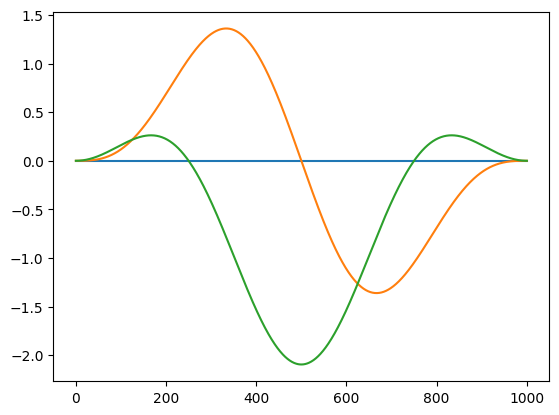

In [90]:
plt.plot(A_ts.transpose())

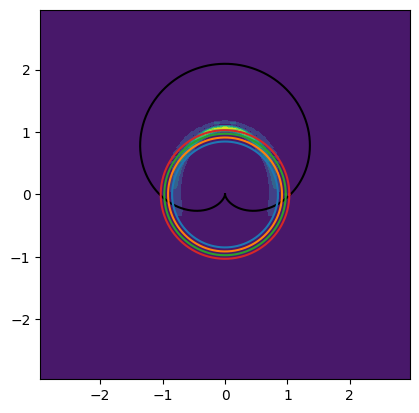

In [99]:
Z,Y = np.meshgrid(k_zs, k_ys)
# print(Y)

fig, ax = plt.subplots()

ax.contourf(Y, Z, matrix)
ax.plot(-A_ts[1], -A_ts[2], 'k-')
ax.set_aspect("equal")

vinkler = np.linspace(0,2*np.pi,100)
for n in range(36,40):
    energy = 2*(-E0-Up+n*wl)
    if energy <0:
        continue 
    førstepeak = np.sqrt(energy)
    plt.plot(førstepeak*np.cos(vinkler),førstepeak*np.sin(vinkler))


In [92]:
x = np.array([[1,1,1,1],
              [2,2,2,2],
              [3,3,3,3]])
print(x[:,0])

[1 2 3]
